# Mar 11-26, 2024: bayesian sbm 

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import pickle 

from scipy import sparse, stats
import glob
from tqdm import tqdm
import ants
from nipype.interfaces import afni


import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

240414-17:02:56,74 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.6.1


In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

gt.seed_rng(args.SEED)
np.random.seed(args.SEED)

In [3]:
args.type = 'spatial'
args.roi_size = 225
args.maintain_symmetry = True
args.brain_div = 'whl'
args.num_rois = 162

DESC = (
    f'type-{args.type}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
)

args.unit = 'seswise' # runwise/seswise/subwise : unit sample of dataset
args.denst = 15 # density of fc matrix

BASE_path = f'{os.environ["HOME"]}/mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = f'{BASE_path}/roi_results'
ROI_RESULTS_path = f'{ROI_path}/{DESC}/{args.unit}/density-{args.denst}'
FC_path = f'{ROI_RESULTS_path}/corr_mats'
SBM_path = f'{ROI_RESULTS_path}/sbms'
NPY_path = f'{ROI_RESULTS_path}/npy'
os.system(f'mkdir -p {NPY_path}')
NII_path = f'{ROI_RESULTS_path}/niis'
os.system(f'mkdir -p {NII_path}/indiv')
os.system(f'mkdir -p {NII_path}/group')

# sbm model class
args.dc = 'dc'
args.sbm = 'h' 

In [4]:
parcels_img = ants.image_read(f'{PARCELS_path}/{DESC}_desc-parcels.nii.gz')
parcels = parcels_img.numpy()
roi_labels = np.loadtxt(f'{PARCELS_path}/{DESC}_desc-labels.txt')

## individual run estimates

In [5]:
def collect_sbm_fits(args, files):
    def get(name):
        l = [s for s in ssr if name in s]
        return l[0].split('-')[-1] if len(l) > 0 else '0'
    
    fits_df = []
    for file in tqdm(files):
        ssr = file.split('/')[-2].split('_')
        sub, ses, run = list(map(get, ['sub', 'ses', 'run']))
        
        with open(f'{file}', 'rb') as f:
            [g, L, pmode, modes, marginals, state, bs, Bs, Bes, dls] = pickle.load(f)
        
        df = pd.DataFrame({
            'sub':[int(sub[-2:])],
            'ses':[int(ses)],
            'run':[int(run)],
            'ssr':[ssr],
            'graph':[g],
            'sbm':[f'sbm-{args.dc}-{args.sbm}'],
            'evidence':[L],
            'state':[state],
            'pmode':[pmode],
            'modes':[modes],
            'marginals':[marginals],
            'bs':[bs],
            'Bs':[Bs],
            'Be':[Bes],
            'dls':[dls],
        })
        fits_df.append(df)
        
    fits_df = pd.concat(fits_df)
    fits_df = fits_df.sort_values(
        by=['sub', 'ses', 'run']
    ).reset_index(drop=True)

    return fits_df

In [6]:
files = glob.glob(f'{SBM_path}/*/sbm-{args.dc}-{args.sbm}*')
fits_df = collect_sbm_fits(args, files)
fits_df.head(n=5)

100%|██████████| 22/22 [02:27<00:00,  6.73s/it]


,sub,ses,run,ssr,graph,sbm,evidence,state,pmode,modes,marginals,bs,Bs,Be,dls
0,1,1,0,"[sub-SLC01, ses-1]","<Graph object, undirected, with 162 vertices a...",sbm-dc-h,-4597.306007,"<NestedBlockState object, with base <BlockStat...",<graph_tool.inference.partition_modes.ModeClus...,[<graph_tool.inference.partition_modes.Partiti...,"[[[0.943, 0.0, 0.0, 0.0, 0.0, 0.044, 0.0, 0.0,...","[[[138, 100, 100, 118, 52, 161, 143, 161, 138,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[12.918875829073437, 12.909365161599718, 13.0...","[4722.156247028745, 4715.891676955815, 4727.44..."
1,2,1,0,"[sub-SLC02, ses-1]","<Graph object, undirected, with 162 vertices a...",sbm-dc-h,-4354.826802,"<NestedBlockState object, with base <BlockStat...",<graph_tool.inference.partition_modes.ModeClus...,[<graph_tool.inference.partition_modes.Partiti...,"[[[0.996, 0.0, 0.0, 0.004, 0.0, 0.0, 0.0, 0.0,...","[[[59, 94, 94, 29, 157, 157, 56, 59, 56, 56, 1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[12.677275574931341, 12.602155991552571, 12.6...","[4470.926087019506, 4470.357644149116, 4471.32..."
2,2,2,0,"[sub-SLC02, ses-2]","<Graph object, undirected, with 162 vertices a...",sbm-dc-h,-4553.289779,"<NestedBlockState object, with base <BlockStat...",<graph_tool.inference.partition_modes.ModeClus...,[<graph_tool.inference.partition_modes.Partiti...,"[[[0.994, 0.0, 0.0, 0.0, 0.006, 0.0, 0.0, 0.0,...","[[[121, 32, 101, 75, 69, 69, 101, 121, 121, 93...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[15.489927344294758, 15.271826635551525, 15.3...","[4671.642580647641, 4681.584446713828, 4679.98..."
3,2,3,0,"[sub-SLC02, ses-3]","<Graph object, undirected, with 162 vertices a...",sbm-dc-h,-4474.539528,"<NestedBlockState object, with base <BlockStat...",<graph_tool.inference.partition_modes.ModeClus...,[<graph_tool.inference.partition_modes.Partiti...,"[[[0.982, 0.0, 0.0, 0.015, 0.0, 0.0, 0.0, 0.0,...","[[[83, 70, 70, 91, 83, 81, 43, 83, 151, 151, 8...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[11.746618088939021, 11.747492737589791, 11.7...","[4590.850612219607, 4608.166749165388, 4604.78..."
4,3,1,0,"[sub-SLC03, ses-1]","<Graph object, undirected, with 162 vertices a...",sbm-dc-h,-4561.712102,"<NestedBlockState object, with base <BlockStat...",<graph_tool.inference.partition_modes.ModeClus...,[<graph_tool.inference.partition_modes.Partiti...,"[[[0.033, 0.0, 0.0, 0.004, 0.0, 0.0, 0.0, 0.0,...","[[[98, 12, 12, 1, 146, 146, 133, 98, 133, 133,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[9.445046891457988, 10.27436683972215, 10.228...","[4662.455679412722, 4665.690488715865, 4666.70..."


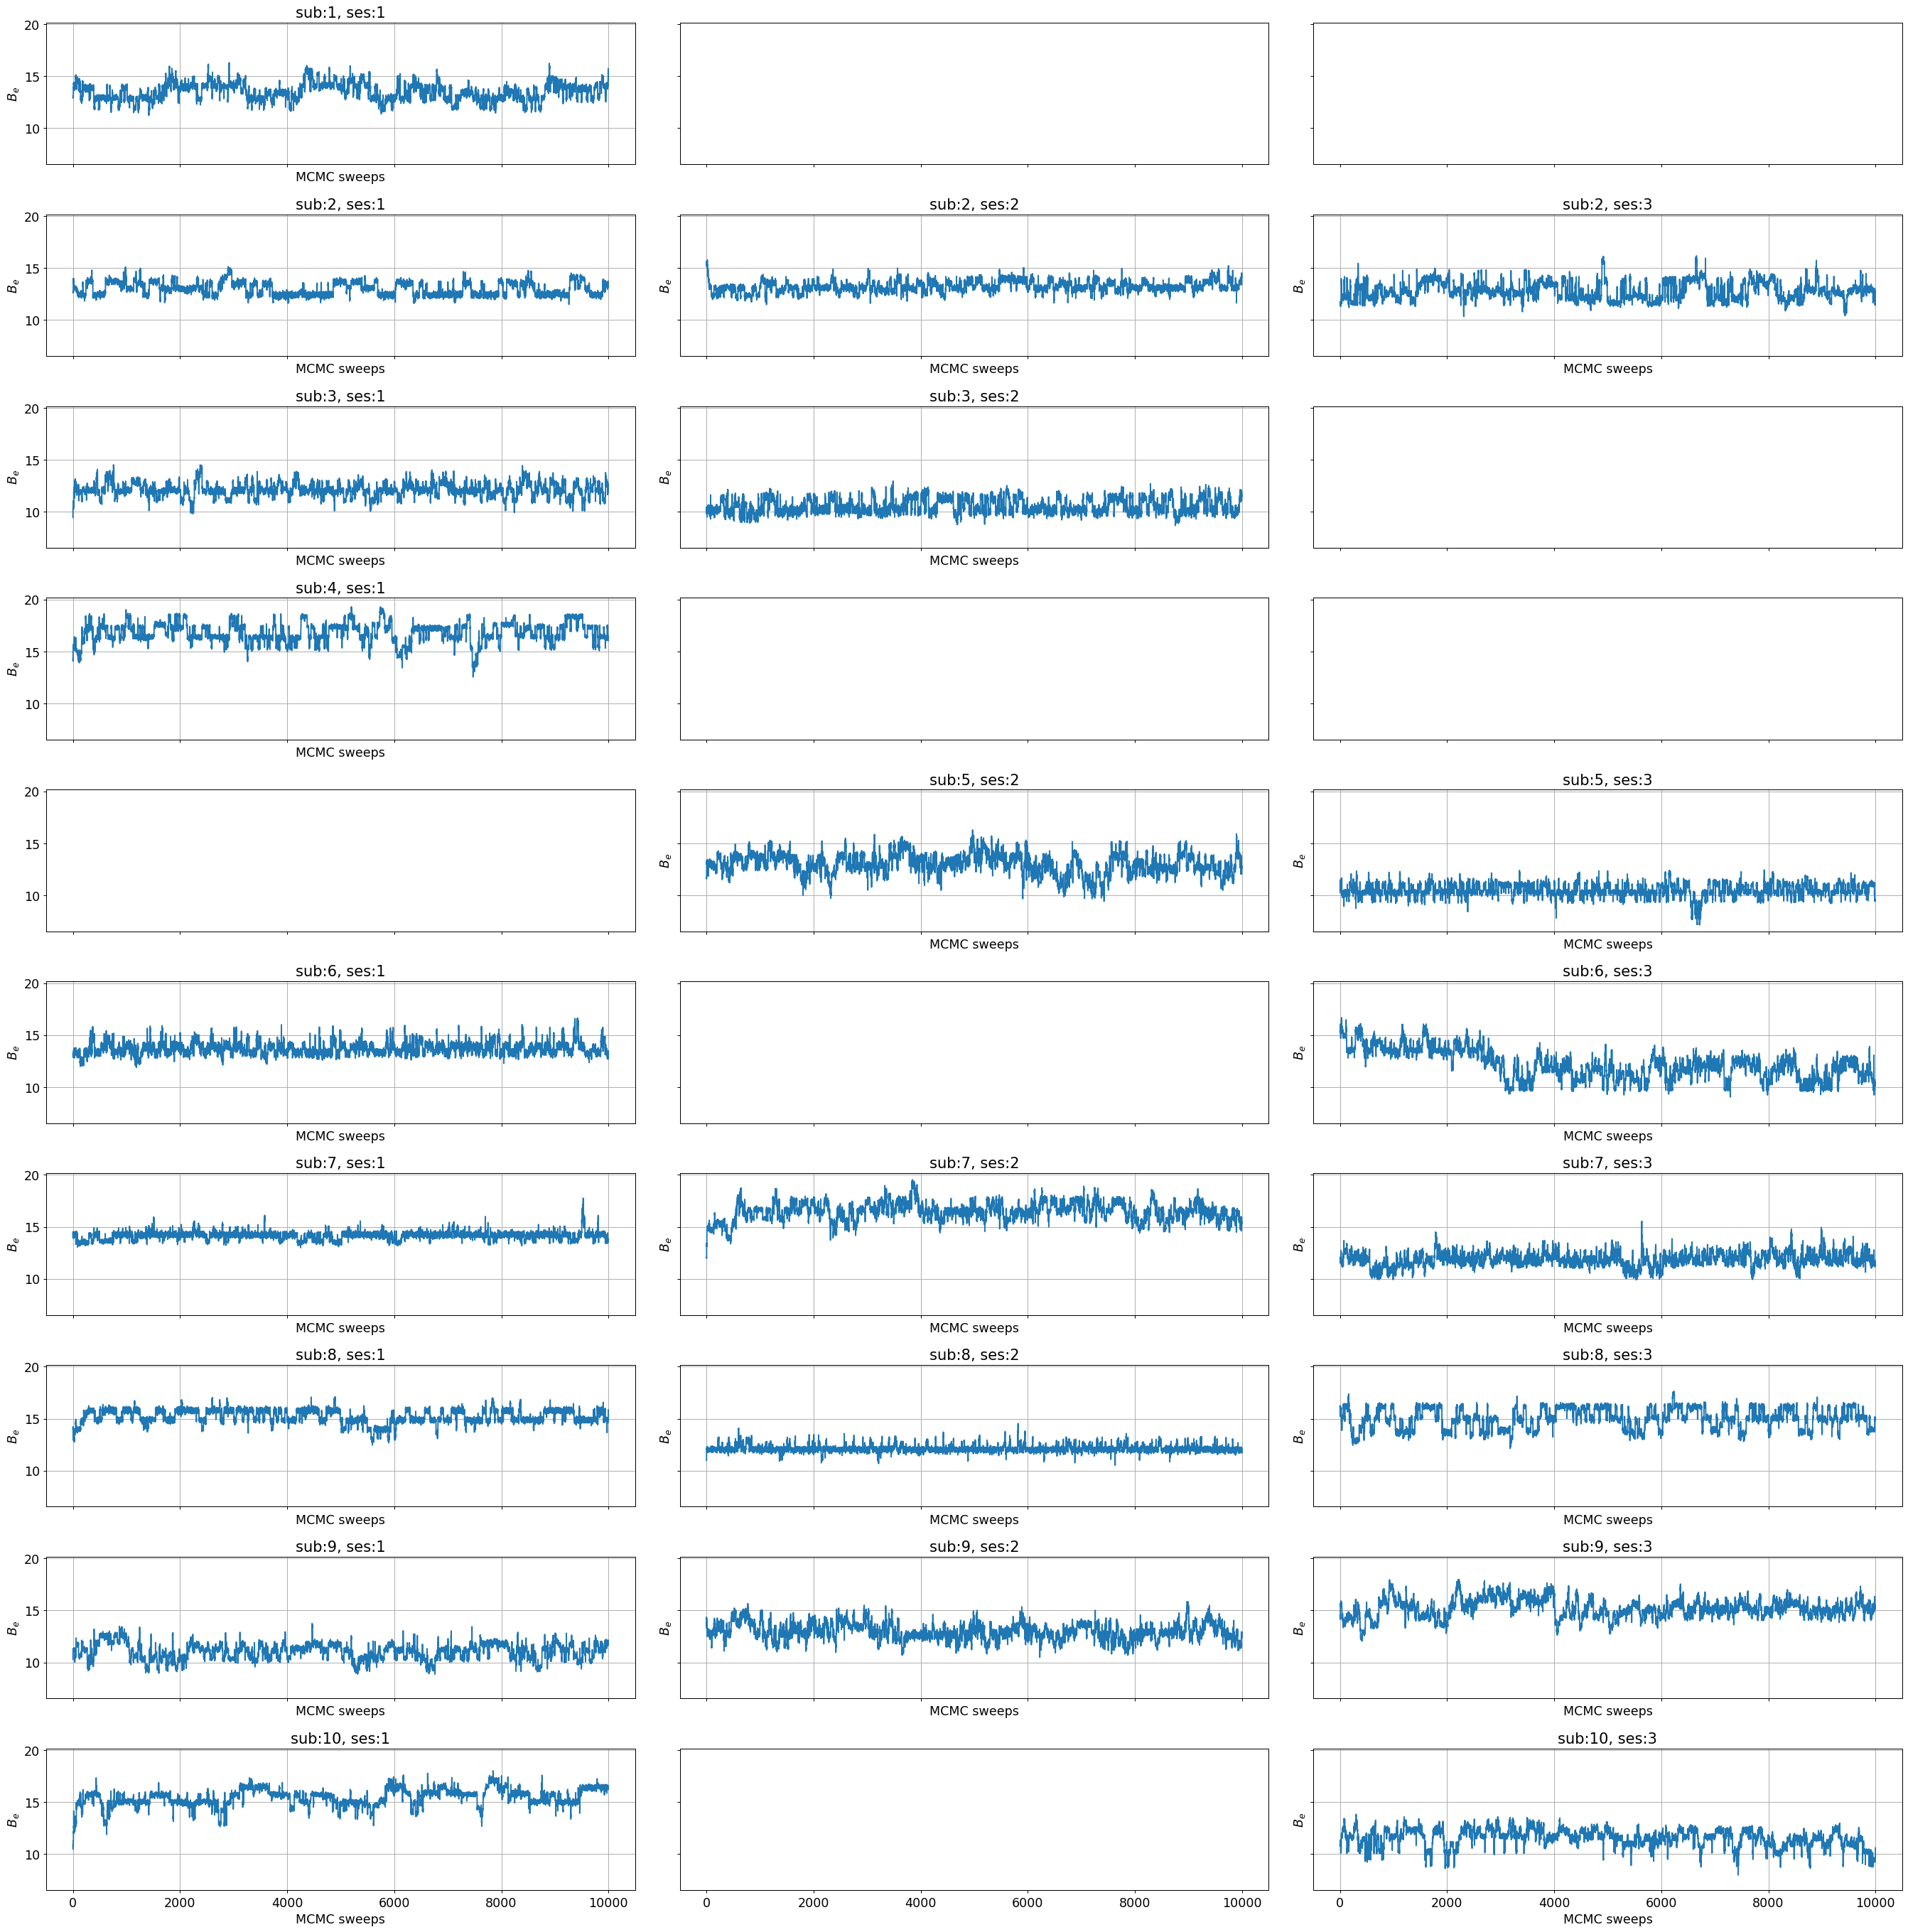

In [7]:
ncols = 3
nrows = 10
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10*ncols, 3*nrows), dpi=90, sharex=True, sharey=True)
fig.tight_layout(h_pad=3, w_pad=2)

for idx, row in fits_df.iterrows():
    sub, ses = row[['sub', 'ses']]
    ax = axs[sub-1, ses-1]
    ax.set(title=f'sub:{sub}, ses:{ses}', xlabel=f'MCMC sweeps', ylabel=f'$B_e$')
    
    Bes = row['Be'] if not 'h' in args.sbm else row['Be'][0]
    ax.plot(Bes)
    ax.grid(True)

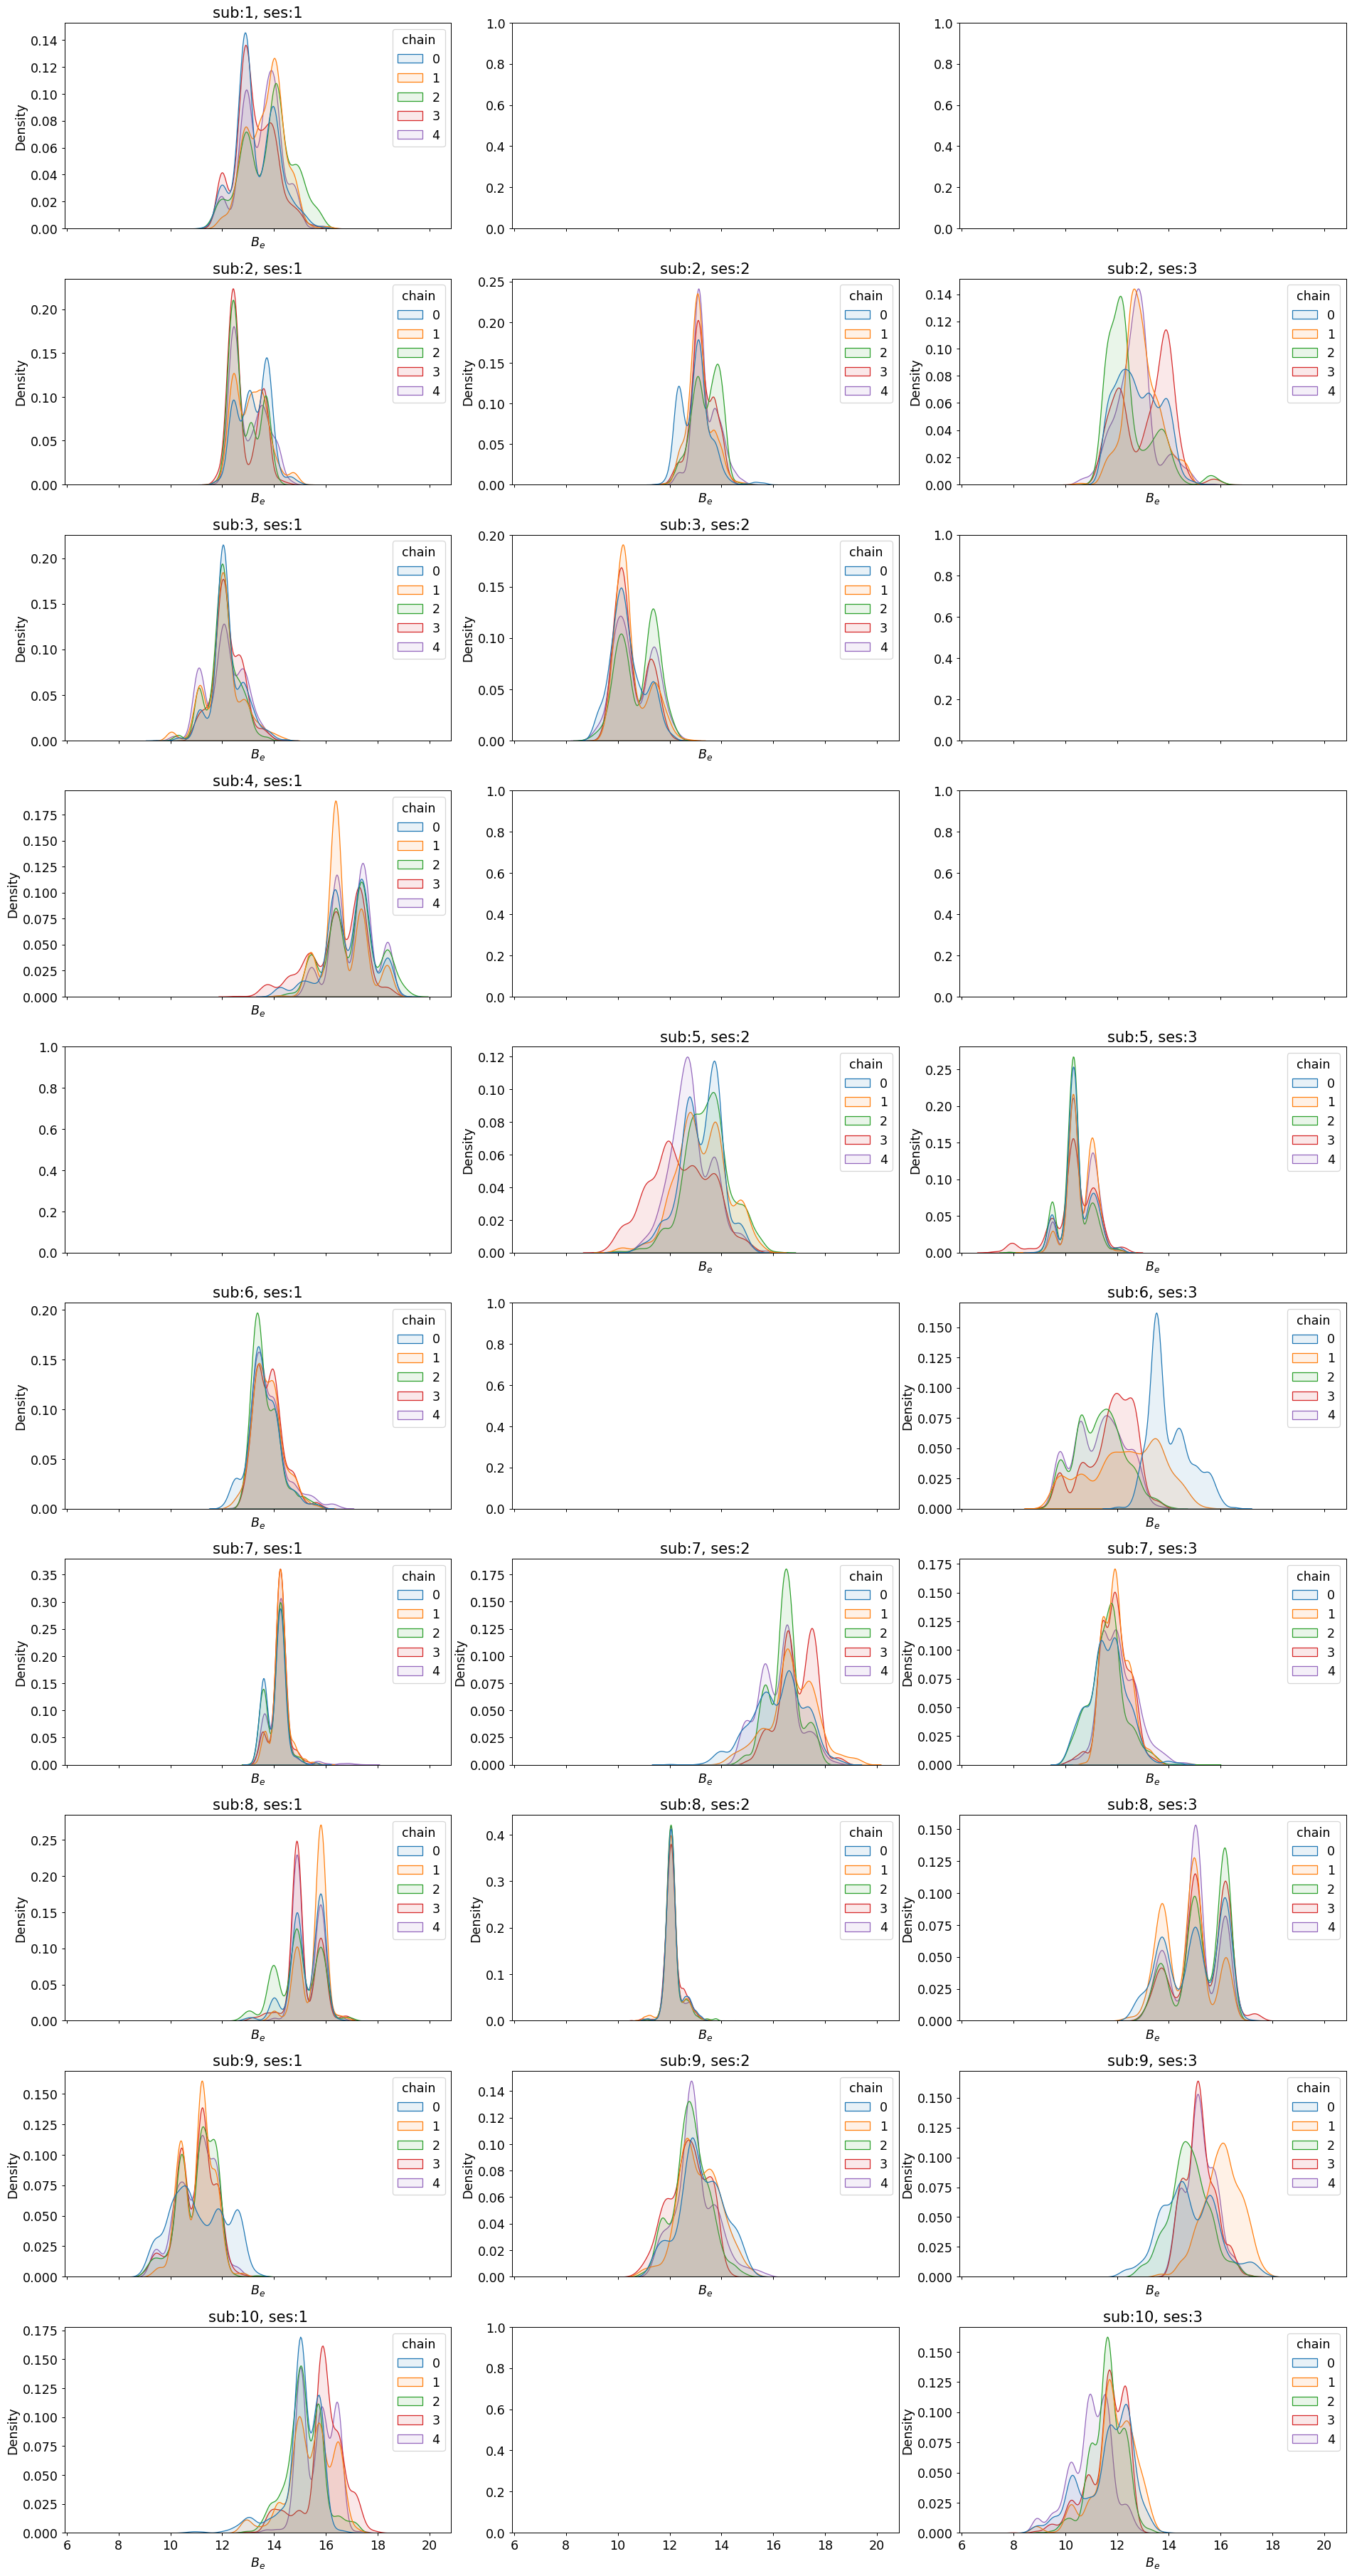

In [8]:
# histograms/ probability densities of `Be`
def prob_density(chain, win_len=2000):
    chain_idxs = []
    for idx_win in range(np.ceil(len(chain)/win_len).astype(int)):
        chain_idxs += [idx_win]*len(chain[idx_win*win_len : (idx_win+1)*win_len])

    win_df = pd.DataFrame({
        'Be':chain,
        'chain':chain_idxs,
    })
    return win_df

ncols = 3
nrows = 10
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7*ncols, 4*nrows), dpi=90, sharex=True, sharey=False)
fig.tight_layout(h_pad=3, w_pad=2)

for idx, row in fits_df.iterrows():
    sub, ses = row[['sub', 'ses']]
    ax = axs[sub-1, ses-1]
    ax.set(title=f'sub:{sub}, ses:{ses}', xlabel=f'$B_e$')
    
    Bes = row['Be'] if not 'h' in args.sbm else row['Be'][0]
    win_df = prob_density(Bes, win_len=2000)
    sns.kdeplot(data=win_df, x='Be', hue='chain', palette='tab10', fill=True, alpha=0.1, ax=ax)